In [1]:
import keras
import keras_tuner

In [2]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
from matplotlib import pyplot as plt 

In [3]:
df = pd.read_csv("diabetes.csv")

In [4]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
# correlation of features with outcome 
df.corr()['Outcome']

Pregnancies                 0.221898
Glucose                     0.466581
BloodPressure               0.065068
SkinThickness               0.074752
Insulin                     0.130548
BMI                         0.292695
DiabetesPedigreeFunction    0.173844
Age                         0.238356
Outcome                     1.000000
Name: Outcome, dtype: float64

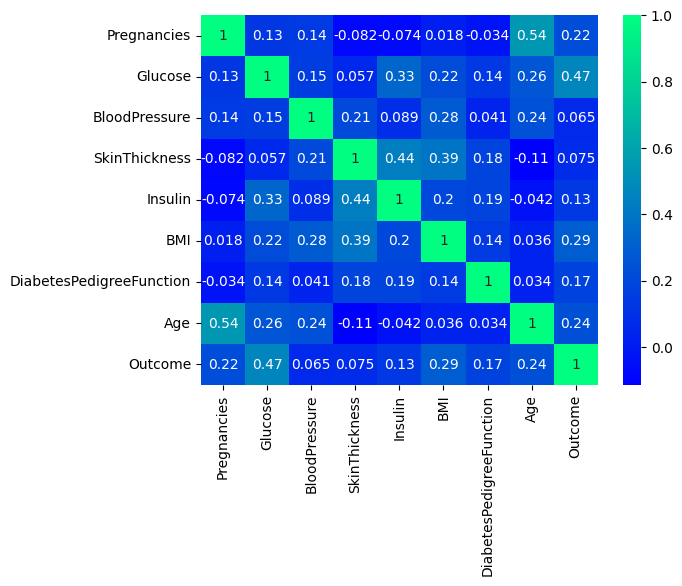

In [6]:
sns.heatmap(df.corr() , cmap = 'winter' , annot = True) 
plt.show()

In [7]:
# extract input feature and target 
X = df.drop(columns = ['Outcome'] , axis = 1)
y = df['Outcome']

In [10]:
X.shape

(768, 8)

In [9]:
y

0      1
1      0
2      1
3      0
4      1
      ..
763    0
764    0
765    0
766    1
767    0
Name: Outcome, Length: 768, dtype: int64

In [11]:
# do the train test split 
from sklearn.model_selection import train_test_split

X_train , X_test , y_train , y_test = train_test_split(X , y , random_state = 42 , test_size = 0.20)

In [12]:
# scale the input columns 
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [13]:
import tensorflow as tf 
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense , Input

In [14]:
model = Sequential()
model.add(Input(shape = (8 , ))) # input layer with 8 features
model.add(Dense(32 , activation = 'relu')) # hidden layer-1
model.add(Dense(1 , activation = 'sigmoid')) # output layer with sigmoid cause binary class 

model.compile(loss = 'binary_crossentropy' , optimizer = 'Adam' , metrics = ['accuracy'])

In [19]:
history = model.fit(X_train_scaled , y_train , batch_size = 32 , epochs = 100 , validation_data = (X_test_scaled , y_test) , verbose = False)

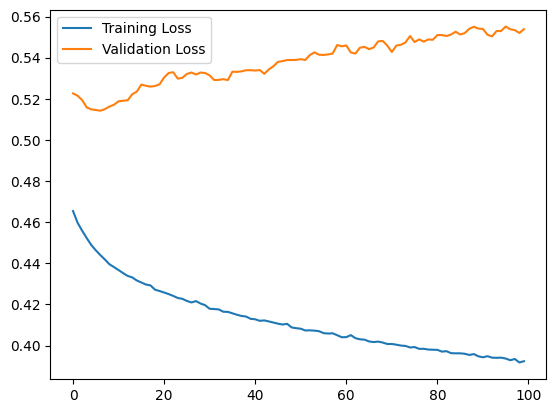

In [20]:
plt.plot(history.history['loss'] , label = 'Training Loss')
plt.plot(history.history['val_loss'] , label = 'Validation Loss')
plt.legend()
plt.show()

## Tune the model architecture

In [24]:
# define the model search space 
import keras
from keras import layers
import keras_tuner as kt 

# a method that choose the optimal optimizer only
def build_model(hp): 
    
    model = keras.Sequential() 

    model.add(layers.Input(shape = (8,)))
    model.add(layers.Dense(32 , activation = 'relu'))
    model.add(layers.Dense(1 , activation = 'sigmoid'))

    optimizers = hp.Choice('optimizer' , values = ['adam' , 'sgd' , 'rmsprop' , 'adadelta'])
    model.compile(optimizer = optimizers , loss = 'binary_crossentropy' , metrics = ['accuracy'])

    return model 

In [25]:
tuner = keras_tuner.RandomSearch(
    build_model , objective = 'val_accuracy' , max_trials = 5
)

Reloading Tuner from .\untitled_project\tuner0.json


In [26]:
tuner.search(X_train_scaled , y_train , epochs = 5 , validation_data = (X_test_scaled , y_test))

Trial 4 Complete [00h 00m 06s]
val_accuracy: 0.551948070526123

Best val_accuracy So Far: 0.7792207598686218
Total elapsed time: 00h 03m 07s


In [28]:
X_train_scaled.shape

(614, 8)

In [38]:
def build_model_test(hp): 
    model = Sequential()
    # input layer 
    model.add(Input(shape = (8,)))
    # hidden layer
    model.add(Dense(32 , activation = 'relu'))
    # output layer
    model.add(Dense(1 , activation = 'sigmoid'))

    # hyper parameters for optimizers
    optimizer = hp.Choice('optimizer' , values = ['adam' , 'sgd' , 'rmsprop' , 'adadelta'])
    
    model.compile(optimizer = optimizer , loss = 'binary_crossentropy' , metrics = ['accuracy'])

    return model

In [47]:
tuner_test = keras_tuner.RandomSearch(
    hypermodel = build_model_test, 
    objective = 'val_accuracy', # maximize validation accruracy
    max_trials = 5, 
    directory = 'tuner_test_results', 
    project_name = 'model_optimizer_test'
)

In [48]:
tuner_test.search(X_train_scaled , y_train , epochs = 5 , validation_data = (X_test_scaled , y_test) , verbose = 1)

Trial 4 Complete [00h 00m 05s]
val_accuracy: 0.7207792401313782

Best val_accuracy So Far: 0.7727272510528564
Total elapsed time: 00h 00m 21s


In [45]:
tuner.directory

'.'

In [49]:
tuner_test.results_summary(5)

Results summary
Results in tuner_test_results\model_optimizer_test
Showing 5 best trials
Objective(name="val_accuracy", direction="max")

Trial 0 summary
Hyperparameters:
optimizer: rmsprop
Score: 0.7727272510528564

Trial 2 summary
Hyperparameters:
optimizer: adam
Score: 0.7597402334213257

Trial 3 summary
Hyperparameters:
optimizer: sgd
Score: 0.7207792401313782

Trial 1 summary
Hyperparameters:
optimizer: adadelta
Score: 0.37012988328933716


In [51]:
for trial_id , trial in tuner_test.oracle.trials.items(): 
    print(f"Trial id: {trial_id}")
    print("Hyperparameters:", trial.hyperparameters.values)
    print("Score:", trial.score)
    print("-" * 60)

Trial id: 0
Hyperparameters: {'optimizer': 'rmsprop'}
Score: 0.7727272510528564
------------------------------------------------------------
Trial id: 1
Hyperparameters: {'optimizer': 'adadelta'}
Score: 0.37012988328933716
------------------------------------------------------------
Trial id: 2
Hyperparameters: {'optimizer': 'adam'}
Score: 0.7597402334213257
------------------------------------------------------------
Trial id: 3
Hyperparameters: {'optimizer': 'sgd'}
Score: 0.7207792401313782
------------------------------------------------------------


In [53]:
# get best parameters
tuner_test.get_best_hyperparameters()[0].values

{'optimizer': 'rmsprop'}

In [54]:
# get the best model(top-1)
model = tuner_test.get_best_models(num_models = 1)[0]

C:\Users\tipto\anaconda3\envs\DL311\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [56]:
model.fit(X_train_scaled , y_train , validation_data = (X_test_scaled , y_test) , epochs = 100 , initial_epoch = 6)

Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.7590 - loss: 0.5023 - val_accuracy: 0.7857 - val_loss: 0.4929
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7704 - loss: 0.4889 - val_accuracy: 0.7857 - val_loss: 0.4892
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7785 - loss: 0.4806 - val_accuracy: 0.7662 - val_loss: 0.4851
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7785 - loss: 0.4737 - val_accuracy: 0.7792 - val_loss: 0.4827
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7866 - loss: 0.4687 - val_accuracy: 0.7727 - val_loss: 0.4824
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7850 - loss: 0.4647 - val_accuracy: 0.7727 - val_loss: 0.4804
Epoch 13/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7850 - loss: 0.4608 - val_accuracy: 0.7792 - val_loss: 0.4806
Epoch 14/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7866 - loss: 0.4576 - val_accuracy: 0.7

In [57]:
new_sample = [5.8, 3.1, 4.0, 1.3, 0.2, 1.1, 0.0, 1.0]
new_sample = np.array(new_sample).reshape(1 , -1)

In [58]:
new_sample.shape

(1, 8)

In [59]:
new_sample_scaled = scaler.transform(new_sample)

C:\Users\tipto\anaconda3\envs\DL311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [60]:
new_sample_scaled

array([[ 0.62144347, -3.67881533, -3.53643731, -1.23847521, -0.69948347,
        -3.99303253, -1.39395817, -2.77596881]])

In [61]:
prediction = model.predict(new_sample_scaled)
prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


array([[5.279984e-07]], dtype=float32)

In [62]:
predicted_class = (prediction > 0.5).astype(int) 
predicted_class

array([[0]])

## Tuning Units and activations together

In [73]:
def build_model(hp): 
    # take the model 
    model = Sequential()

    # make the input layer 
    model.add(Input(shape = (8 , )))

    # hidden layer-1 
    model.add(
        Dense(
           # tune the unit of nodes 
           units = hp.Int('units' , min_value = 8 , max_value = 128 , step = 8), 
           activation = hp.Choice('activation' , ['relu' , 'tanh']) 
        )
    )
    # output layer 
    model.add(Dense(1 , activation = 'sigmoid'))

    # tune the learning rate 
    learning_rate = hp.Float('lr' , min_value = 1e-4 , max_value = 1e-2 , sampling = 'log')
    model.compile(
        optimizer = keras.optimizers.Adam(learning_rate = learning_rate),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [74]:
tuner_2 = keras_tuner.RandomSearch(
    hypermodel = build_model, 
    objective = 'val_loss', 
    max_trials = 10, 
    directory = "tuning_units_lr", 
    project_name = "tuning_units_lr_project"
)

Reloading Tuner from tuning_units_lr\tuning_units_lr_project\tuner0.json


In [75]:
print((X_train_scaled.shape , y_train.shape))
print((X_test_scaled.shape , y_test.shape))

((614, 8), (614,))
((154, 8), (154,))


In [76]:
tuner_2.search(
    X_train_scaled , y_train , epochs = 5 , validation_data = (X_test_scaled , y_test) , verbose = 1 
)

Trial 10 Complete [00h 00m 06s]
val_loss: 0.6197953224182129

Best val_loss So Far: 0.49480903148651123
Total elapsed time: 00h 05m 56s


In [77]:
model = tuner_2.get_best_models(num_models = 1)[0]

C:\Users\tipto\anaconda3\envs\DL311\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [78]:
def model_builder(hp): 
    # create a model 
    model = Sequential()
    # add the input layer 
    model.add(Input(shape = (8 , )))

    # now try out different different number of hidden layers
    for i in range(hp.Int('num_layers' , min_value = 1 , max_value = 10)): 
        model.add(Dense(72 , activation = 'relu'))
    # output layer 
    model.add(Dense(1 , activation = 'sigmoid'))

    model.compile(optimizer = 'rmsprop' , loss = 'binary_crossentropy' , metrics = ['accuracy'])

    return model 

In [79]:
tuner = keras_tuner.RandomSearch(
    model_builder , 
    objective = 'val_accuracy', 
    max_trials = 5,
    directory = 'layer_tuning', 
    project_name = 'layer_tuning'
)

In [80]:
tuner.search(X_train_scaled , y_train , epochs = 10 , validation_data = (X_test_scaled , y_test))

Trial 5 Complete [00h 00m 06s]
val_accuracy: 0.7662337422370911

Best val_accuracy So Far: 0.7857142686843872
Total elapsed time: 00h 00m 39s


In [83]:
tuner.get_best_hyperparameters()[0].values

{'num_layers': 5}

In [84]:
model = tuner.get_best_models()[0]

C:\Users\tipto\anaconda3\envs\DL311\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [86]:
history = model.fit(X_train_scaled , y_train , epochs = 100 , initial_epoch = 11 , validation_data = (X_test_scaled , y_test))

Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.7866 - loss: 0.4401 - val_accuracy: 0.7597 - val_loss: 0.5370
Epoch 13/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8094 - loss: 0.4151 - val_accuracy: 0.7662 - val_loss: 0.5269
Epoch 14/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8013 - loss: 0.3989 - val_accuracy: 0.6948 - val_loss: 0.5720
Epoch 15/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8241 - loss: 0.3895 - val_accuracy: 0.7468 - val_loss: 0.5466
Epoch 16/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8176 - loss: 0.3878 - val_accuracy: 0.7922 - val_loss: 0.5624
Epoch 17/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8290 - loss: 0.3758 - val_accuracy: 0.7597 - val_loss: 0.6306
Epoch 18/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8192 - loss: 0.3699 - val_accuracy: 0.7273 - val_loss: 0.5511
Epoch 19/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8485 - loss: 0.3541 - val_accuracy: 0

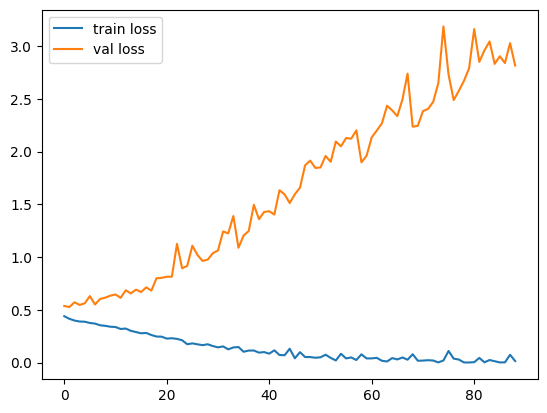

In [87]:
plt.plot(history.history['loss'] , label = 'train loss')
plt.plot(history.history['val_loss'] , label = 'val loss')
plt.legend()
plt.show()

In [88]:
from keras.models import Sequential
from keras.layers import Dense , Input
import keras_tuner
from keras.optimizers import Adam , SGD , RMSprop , Adadelta


def build_full_model(hp): 
    # create the model
    model = Sequential()
    model.add(Input(shape = (8 , ))) # Input layer for 8 features

    # 1. Tune the number of hidden layers 
    num_layers = hp.Int('num_layers' , 1 , 7) # try 1 to 7 hidden layers

    for layer in range(num_layers): 
        # 2. Tune the number of units per layer
        units = hp.Int(f"units_{layer}" , min_value = 16 , max_value = 128 , step = 16)

        # 3. Tune the activation function for each layer
        activation = hp.Choice(f"activation_{layer}" , ['relu' , 'tanh' , 'elu'])

        # as we define the units and activation now add the the layer
        model.add(Dense(units , activation = activation))

    # add the output layer
    model.add(Dense(1 , activation = 'sigmoid'))

    # 4. Tune the optimizer
    optimizer_choice = hp.Choice('optimizer' , ['adam' , 'rmsprop' , 'sgd' , 'adadelta'])

    # 5. Tune the learning rate
    learning_rate = hp.Float('lr' , min_value = 1e-4 , max_value = 1e-1 , sampling = 'log')

    # create the optimizer
    if optimizer_choice  == 'adam':
        optimizer = Adam(learning_rate = learning_rate)
    elif optimizer_choice == 'rmsprop': 
        optimizer = RMSprop(learning_rate = learning_rate)
    elif optimizer_choice == 'sgd': 
        optimizer = SGD(learning_rate = learning_rate) 
    else:
        optimizer = Adadelta(learning_rate = learning_rate)

    # compile the model
    model.compile(
        optimizer = optimizer, 
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    return model

In [89]:
tuner = keras_tuner.RandomSearch(
    hypermodel = build_full_model,
    objective = "val_accuracy",
    max_trials = 10,  # total combinations to try
    executions_per_trial = 1, 
    directory = "full_hyperparam_tuning",
    project_name = "full_model_search"
)

In [90]:
tuner.search(
    X_train_scaled , y_train,
    validation_data = (X_test_scaled , y_test),
    epochs = 20,
    batch_size = 32,
    verbose = 1
)

Trial 10 Complete [00h 00m 10s]
val_accuracy: 0.7792207598686218

Best val_accuracy So Far: 0.7922077775001526
Total elapsed time: 00h 01m 40s


In [91]:
best_model = tuner.get_best_models(num_models = 1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials = 1)[0]

C:\Users\tipto\anaconda3\envs\DL311\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [93]:
print("Best Hyperparameters:")
print(f"Number of layers: {best_hyperparameters.get('num_layers')}")

for i in range(best_hyperparameters.get('num_layers')):
    print(f"Layer {i} units: {best_hyperparameters.get(f'units_{i}')}, activation: {best_hyperparameters.get(f'activation_{i}')}")

print(f"Optimizer: {best_hyperparameters.get('optimizer')}")
print(f"Learning rate: {best_hyperparameters.get('lr')}")

Best Hyperparameters:
Number of layers: 5
Layer 0 units: 16, activation: elu
Layer 1 units: 48, activation: relu
Layer 2 units: 96, activation: elu
Layer 3 units: 32, activation: relu
Layer 4 units: 48, activation: tanh
Optimizer: adam
Learning rate: 0.0003614812626559304


In [94]:
best_model.fit(X_train_scaled , y_train , epochs = 100 , initial_epoch = 20 , verbose = 1 , validation_data = (X_test_scaled , y_test))

Epoch 21/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.7915 - loss: 0.4285 - val_accuracy: 0.7727 - val_loss: 0.4911
Epoch 22/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7915 - loss: 0.4211 - val_accuracy: 0.7792 - val_loss: 0.4951
Epoch 23/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7915 - loss: 0.4185 - val_accuracy: 0.7662 - val_loss: 0.4955
Epoch 24/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8046 - loss: 0.4148 - val_accuracy: 0.7792 - val_loss: 0.5017
Epoch 25/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8062 - loss: 0.4108 - val_accuracy: 0.7727 - val_loss: 0.5062
Epoch 26/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8029 - loss: 0.4070 - val_accuracy: 0.7792 - val_loss: 0.5059
Epoch 27/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8013 - loss: 0.4064 - val_accuracy: 0.7922 - val_loss: 0.5081
Epoch 28/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8127 - loss: 0.4018 - val_accuracy: